In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import shap
from trainer import trainer
import seaborn as sns
from Plots import plot_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm
from umap import UMAP
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score,recall_score
%matplotlib inline
shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


#### Import data saved

In [2]:
Xtrain=pd.read_pickle("./Data/XtrainForModel.pkl")
ytrain=pd.read_pickle("./Data/ytrainForModel.pkl")
test=pd.read_pickle("./Data/validForModel.pkl").dropna()
Xtest=test[['basegrd', 'baseucva', 'familyHistory', 'basesef','wearGlass']]
ytest=test.outcome

#### Import model trained

In [3]:
mytrainer=trainer.load_model("./Model_1708489668.pkl")
cv=StratifiedKFold(10,random_state=1234,shuffle=True)
models=mytrainer.get_best_estimator()

In [8]:
# AUC & Brierscore
cv_scores=mytrainer.get_metrics(Xtrain,ytrain,scores=['roc_auc','neg_brier_score','balanced_accuracy'],summary=False,cv=cv,return_train_score=True)

In [9]:
performance=pd.DataFrame(cv_scores)

In [10]:
performance.map(np.mean)

,cat,ANN,Logistic,rf,xgb,gbm,ada,GB
fit_time,23.917287,24.925843,1.034922,36.785076,8.983925,5.534008,8.989908,0.379571
score_time,0.270223,0.228026,0.124792,0.562335,0.195520,0.173402,0.576608,0.104170
test_roc_auc,0.890348,0.884010,0.887753,0.889236,0.890052,0.889930,0.880435,0.874873
train_roc_auc,0.892550,0.884067,0.888023,0.890065,0.893800,0.891287,0.880854,0.874907
test_neg_brier_score,-0.132084,-0.020515,-0.135745,-0.133709,-0.180713,-0.133244,-0.240940,-0.111041
train_neg_brier_score,-0.131988,-0.020520,-0.135739,-0.133653,-0.180564,-0.133190,-0.240940,-0.111033
test_balanced_accuracy,0.832512,0.500020,0.832734,0.832975,0.828702,0.833178,0.500000,0.803807
train_balanced_accuracy,0.834218,0.500013,0.832862,0.833266,0.830275,0.833364,0.500000,0.803906


In [32]:
performance.map(np.std)

,cat,ANN,Logistic,rf,xgb,gbm,ada,GB
fit_time,2.475820,0.744068,0.024805,0.654072,0.076435,2.083870,0.210405,0.025325
score_time,0.039088,0.021505,0.012997,0.053321,0.007102,0.055820,0.044224,0.008655
test_roc_auc,0.004706,0.004221,0.004253,0.004391,0.004423,0.004392,0.034016,0.004481
train_roc_auc,0.000385,0.000682,0.000478,0.000503,0.000442,0.000440,0.030158,0.000523
test_neg_brier_score,0.001890,0.000130,0.001875,0.001767,0.002266,0.001741,0.002303,0.002277
train_neg_brier_score,0.001001,0.000043,0.000240,0.000341,0.000401,0.000296,0.002301,0.000295


In [5]:
models=mytrainer.get_best_estimator()

In [4]:
def cut_off_metircs(model,X,y,cv):
    yprob=model.predict_proba(X)[:,1]
    fpr,tpr,cutoff=roc_curve(y,yprob,pos_label=1)
    index=(tpr-fpr).argmax()
    best_cut_off=cutoff[index]
    trainList,testList=[],[]
    X=np.array(X)
    y=np.array(y)
    print(f"Best cutoff:{best_cut_off}")
    for train,test in cv.split(X,y):
        ytrainpred,ytestpred=yprob[train]>=best_cut_off,yprob[test]>=best_cut_off
        ytrain,ytest=y[train],y[test]
        sens=((ytrain==1) & (ytrainpred==1)).sum()/(ytrain==1).sum()
        spec=((ytrain==0) & (ytrainpred==0)).sum()/(ytrain==0).sum()
        acc=(ytrain==ytrainpred).sum()/ytrain.shape[0]
        trainList.append((sens,spec,acc))
        sens=((ytest==1) & (ytestpred==1)).sum()/(ytest==1).sum()
        spec=((ytest==0) & (ytestpred==0)).sum()/(ytest==0).sum()
        acc=(ytest==ytestpred).sum()/ytest.shape[0]
        testList.append((sens,spec,acc))
    return trainList,testList

In [27]:
trainList,testList=cut_off_metircs(models['cat'],Xtrain,ytrain,cv)
print(np.array(trainList)[:,0].mean(),np.array(trainList)[:,0].std())
print(np.array(trainList)[:,1].mean(),np.array(trainList)[:,1].std())
print(np.array(trainList)[:,2].mean(),np.array(trainList)[:,2].std())
print(np.array(testList)[:,0].mean(),np.array(testList)[:,0].std())
print(np.array(testList)[:,1].mean(),np.array(testList)[:,1].std())
print(np.array(testList)[:,2].mean(),np.array(testList)[:,2].std())

Best cutoff:0.4450380472264678
0.8748783509419441 0.0009271584378128476
0.7946408332980726 0.0003129185382770353
0.7964930072370835 0.0003092047448264081
0.8748781100293618 0.00834739385123189
0.7946408298202569 0.0028162614884810074
0.7964930106051147 0.0027828108088167715


In [81]:
trainList,testList=cut_off_metircs(models['ANN'],Xtrain,ytrain,cv)
print(np.array(trainList)[:,0].mean(),np.array(trainList)[:,0].std())
print(np.array(trainList)[:,1].mean(),np.array(trainList)[:,1].std())
print(np.array(trainList)[:,2].mean(),np.array(trainList)[:,2].std())
print(np.array(testList)[:,0].mean(),np.array(testList)[:,0].std())
print(np.array(testList)[:,1].mean(),np.array(testList)[:,1].std())
print(np.array(testList)[:,2].mean(),np.array(testList)[:,2].std())

0.8718198060516198 0.0009211028786105679
0.7850715967662124 0.00030718797734176725
0.7870740615514686 0.0003045735548282886
0.8718183047442436 0.008291779123475465
0.7850715931903336 0.0027646921634687715
0.7870740676635762 0.0027411320167080367


In [82]:
trainList,testList=cut_off_metircs(models['Logistic'],Xtrain,ytrain,cv)
print(np.array(trainList)[:,0].mean(),np.array(trainList)[:,0].std())
print(np.array(trainList)[:,1].mean(),np.array(trainList)[:,1].std())
print(np.array(trainList)[:,2].mean(),np.array(trainList)[:,2].std())
print(np.array(testList)[:,0].mean(),np.array(testList)[:,0].std())
print(np.array(testList)[:,1].mean(),np.array(testList)[:,1].std())
print(np.array(testList)[:,2].mean(),np.array(testList)[:,2].std())

0.8658417816055008 0.0010052001325183818
0.795038319614852 0.00031722612591322683
0.7966727214161491 0.0003121641914436184
0.8658410601143564 0.009048838056024295
0.7950383167019954 0.0028550406096295717
0.796672729015677 0.0028094462625973936


In [83]:
trainList,testList=cut_off_metircs(models['rf'],Xtrain,ytrain,cv)
print(np.array(trainList)[:,0].mean(),np.array(trainList)[:,0].std())
print(np.array(trainList)[:,1].mean(),np.array(trainList)[:,1].std())
print(np.array(trainList)[:,2].mean(),np.array(trainList)[:,2].std())
print(np.array(testList)[:,0].mean(),np.array(testList)[:,0].std())
print(np.array(testList)[:,1].mean(),np.array(testList)[:,1].std())
print(np.array(testList)[:,2].mean(),np.array(testList)[:,2].std())

0.8716807765113146 0.000922513945341883
0.7918124389208184 0.0003235566910202876
0.7936560913864343 0.00032140226320314156
0.8716788363467778 0.008304733138719282
0.7918124308274868 0.002912010083792499
0.7936560946113685 0.002892587254920477


In [84]:
trainList,testList=cut_off_metircs(models['xgb'],Xtrain,ytrain,cv)
print(np.array(trainList)[:,0].mean(),np.array(trainList)[:,0].std())
print(np.array(trainList)[:,1].mean(),np.array(trainList)[:,1].std())
print(np.array(trainList)[:,2].mean(),np.array(trainList)[:,2].std())
print(np.array(testList)[:,0].mean(),np.array(testList)[:,0].std())
print(np.array(testList)[:,1].mean(),np.array(testList)[:,1].std())
print(np.array(testList)[:,2].mean(),np.array(testList)[:,2].std())

0.8764076042968533 0.0006068531115548312
0.7899071326414967 0.0003356596810549326
0.7919038786643879 0.00032853877130230254
0.8764064673157161 0.005462252693616389
0.7899071244411593 0.003020939909340728
0.791903882539887 0.002956818706253118


In [66]:
trainList,testList=cut_off_metircs(models['gbm'],Xtrain,ytrain,cv)
print(np.array(trainList)[:,0].mean(),np.array(trainList)[:,0].std())
print(np.array(trainList)[:,1].mean(),np.array(trainList)[:,1].std())
print(np.array(testList)[:,0].mean(),np.array(testList)[:,0].std())
print(np.array(testList)[:,1].mean(),np.array(testList)[:,1].std())

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
0.8708460726179984 0.0055820540290624126
0.7948346454335221 0.0020266635891430713
0.8708455030134447 0.007845949004511455
0.7948346419733804 0.002848605163389721


In [67]:
trainList,testList=cut_off_metircs(models['ada'],Xtrain,ytrain,cv)
print(np.array(trainList)[:,0].mean(),np.array(trainList)[:,0].std())
print(np.array(trainList)[:,1].mean(),np.array(trainList)[:,1].std())
print(np.array(testList)[:,0].mean(),np.array(testList)[:,0].std())
print(np.array(testList)[:,1].mean(),np.array(testList)[:,1].std())

0.8330321487162342 0.007894389901963037
0.7510487415232614 0.001612154374958511
0.8330321820429608 0.011096105369472503
0.7510487432965917 0.0022659859514659


In [73]:
models['GB'].fit(Xtrain,ytrain)
trainList,testList=cut_off_metircs(models['GB'],Xtrain,ytrain,cv)
print(np.array(trainList)[:,0].mean(),np.array(trainList)[:,0].std())
print(np.array(trainList)[:,1].mean(),np.array(trainList)[:,1].std())
print(np.array(testList)[:,0].mean(),np.array(testList)[:,0].std())
print(np.array(testList)[:,1].mean(),np.array(testList)[:,1].std())

0.879186539621392 0.005856989295180972
0.7727790841671582 0.0020563256981992
0.8791850177715963 0.008232359737171312
0.7727790820794211 0.0028902970672855743


In [10]:
from sklearn.metrics import roc_auc_score,balanced_accuracy_score,brier_score_loss
def get_validation(model,X,y):
   prob=model.predict_proba(X)[:,1]
   pred=model.predict(X)
   fpr,tpr,cutoff=roc_curve(y,prob,pos_label=1)
   index=(tpr-fpr).argmax()
   best_cut_off=cutoff[index]
   auc=roc_auc_score(y,prob)
   acc=balanced_accuracy_score(y,pred)
   bs=brier_score_loss(y,prob)
   ypred=(prob>=best_cut_off)
   sens=((y==1) & (ypred==1)).sum()/(y==1).sum()
   spec=((y==0) & (ypred==0)).sum()/(y==0).sum()
   print(f"AUC:{auc}\tacc:{acc}\tBS:{bs}\tSens:{sens}\tSpec:{spec}")

In [13]:
for m in models:
    print(m)
    try: 
        get_validation(models[m],Xtest,ytest)
    except Exception as e:
        models[m].fit(Xtrain,ytrain)
        get_validation(models[m],Xtest,ytest)

cat
AUC:0.8909713065296875	acc:0.8342702250518639	BS:0.13319340662192855	Sens:0.8618210862619808	Spec:0.8114866898894766
ANN
AUC:0.8841305680575209	acc:0.4999892486990926	BS:0.022832458390072013	Sens:0.865814696485623	Spec:0.7972304648862513
Logistic
AUC:0.8881541651364097	acc:0.833960000214339	BS:0.13792168268974633	Sens:0.8514376996805112	Spec:0.8185395432847374
rf
AUC:0.888708793148955	acc:0.834299353177006	BS:0.13645411017258308	Sens:0.8594249201277955	Spec:0.8134434266546252
xgb
AUC:0.889349096664019	acc:0.8279417791980945	BS:0.18267304816141583	Sens:0.8586261980830671	Spec:0.8121102653421064
gbm
AUC:0.8895117659077003	acc:0.8323748703145797	BS:0.13511286716513676	Sens:0.8570287539936102	Spec:0.8150346191889218
ada
AUC:0.8803549550581882	acc:0.5	BS:0.241007795470029	Sens:0.8586261980830671	Spec:0.8150991269943663
GB
AUC:0.8744470465111582	acc:0.8078980052592754	BS:0.11535066290361905	Sens:0.8522364217252396	Spec:0.8108846170386617


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


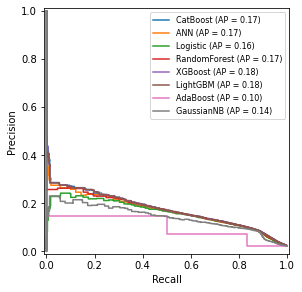

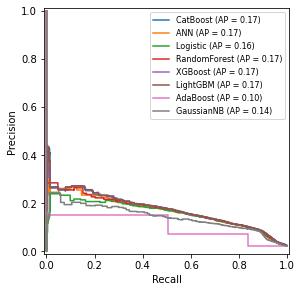

In [126]:
plt.rc("legend", fontsize=8)
titles=['CatBoost','ANN','Logistic','RandomForest','XGBoost','LightGBM','AdaBoost','GaussianNB']
models=list(mytrainer.models.values())
plot_curve(models,Xtrain,ytrain,type="pr",labels=titles,file="./Plots/pr_train.jpg")
plot_curve(models,Xtest,ytest,type="pr",labels=titles,file="./Plots/pr_test.jpg")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


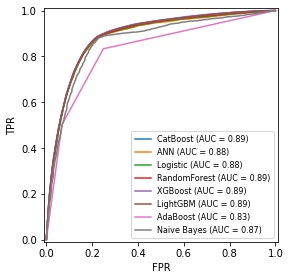

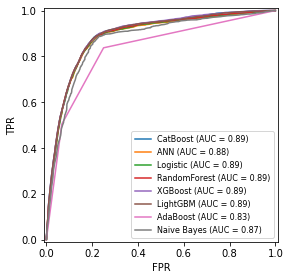

In [5]:
plt.rc("legend", fontsize=8)
titles=['CatBoost','ANN','Logistic','RandomForest','XGBoost','LightGBM','AdaBoost','Naive Bayes']
models=list(mytrainer.models.values())
plot_curve(models,Xtrain,ytrain,type="roc",labels=titles,file="./Plots/roc_train.jpg")
plot_curve(models,Xtest,ytest,type="roc",labels=titles,file="./Plots/roc_test.jpg")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


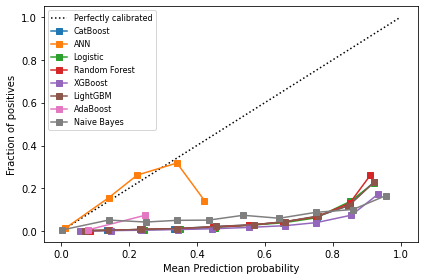

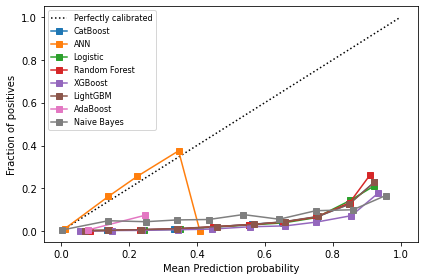

In [5]:
plt.rc("legend", fontsize=8)
titles=['CatBoost','ANN','Logistic','Random Forest','XGBoost','LightGBM','AdaBoost','Naive Bayes']
models=list(mytrainer.models.values())
plot_curve(models,Xtrain,ytrain,type="cr",labels=titles,file="./Plots/cr_train.jpg",n_bins=10)
plot_curve(models,Xtest,ytest,type="cr",labels=titles,file="./Plots/cr_test.jpg",n_bins=10)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


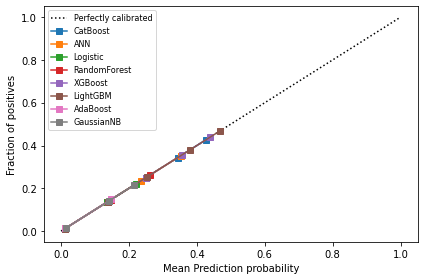

In [6]:
models=mytrainer.addCalibration(method="isotonic",cv="prefit",n_jobs=-1)
titles=['CatBoost','ANN','Logistic','RandomForest','XGBoost','LightGBM','AdaBoost','GaussianNB']
models=list(models.values())
plot_curve(models,Xtrain,ytrain,type="cr",labels=titles,file="./Plots/cr_train_calibrated.jpg",n_bins=10)

In [9]:
catboost=mytrainer.get_best_estimator()['cat']

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating i

Text(0.0, 1.0, 'Developed High Myopia')

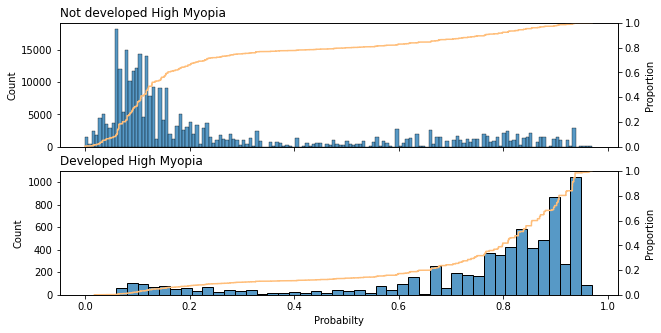

In [11]:
# 预测概率图
pred=catboost.predict_proba(Xtrain)[:,1]
data={
    'prop':pred,
    'ytrue':ytrain
}
data=pd.DataFrame(data)    
fig,(ax1,ax2)=plt.subplots(2,1,sharex=True,figsize=(10, 5))
#fig.tight_layout()
sns.histplot(data=data[data['ytrue']==0],x='prop',ax=ax1)
sns.histplot(data=data[data['ytrue']==1],x='prop',ax=ax2)
ax12=ax1.twinx()
sns.ecdfplot(data[data['ytrue']==0]['prop'],ax=ax12,color="#FFBE7A")
ax22=ax2.twinx()
sns.ecdfplot(data[data['ytrue']==1]['prop'],ax=ax22,color="#FFBE7A")
ax2.set(xlabel="Probabilty")
ax1.set_title("Not developed High Myopia",loc="left")
ax2.set_title("Developed High Myopia",loc="left")

In [13]:
fig.tight_layout()
fig.savefig("./Plots/probabality.jpg",dpi=300)

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating i

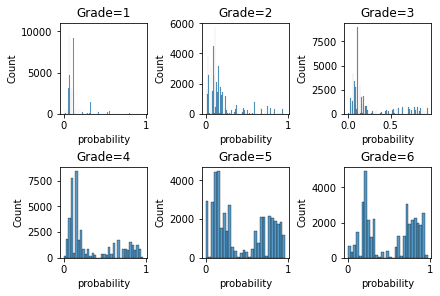

In [19]:
# 分年级预测概率图
fig, axs = plt.subplots(ncols=3, nrows=2,layout="constrained")
i=1
for r in range(2):
    for c in range(3):
        sns.histplot(x=pred[Xtrain["basegrd"]==i],ax=axs[r,c])
        axs[r,c].set_xlabel("probability")
        axs[r,c].set_title(f"Grade={i}")
        i+=1
fig.savefig("./Plots/probabality_grade.jpg",dpi=300)

#### 计算Shap值并可视化

In [4]:
catboost=mytrainer.get_best_estimator()['cat']

In [5]:
featurenames=Xtrain.columns.to_list()
explainer = shap.TreeExplainer(catboost,feature_names=featurenames)
shap_values =explainer.shap_values(Xtrain)

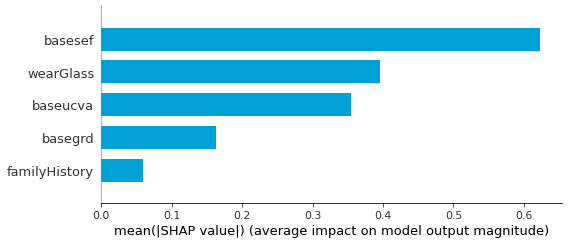

In [6]:
shap.summary_plot(shap_values,Xtrain,plot_type="bar",color="#00A1D5",show=False)
plt.savefig("./Plots/Variables_importance.jpg",dpi=300)

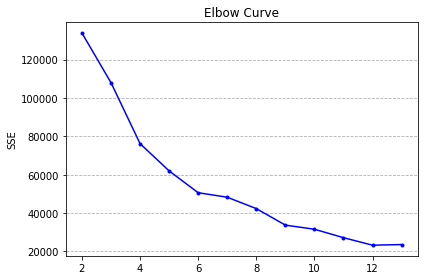

In [25]:
s = pd.DataFrame(shap_values,columns=featurenames)
sse=[]
for k in range(2,14):
    kmeans=KMeans(n_clusters=k,n_init="auto")
    kmeans.fit(s)
    sse.append(kmeans.inertia_)

plt.plot(range(2,14),sse,'b.-')
plt.grid(axis="y",linestyle="--")
plt.ylabel("SSE")
plt.title("Elbow Curve")
plt.tight_layout()
plt.savefig("./Plots/elbow.jpg",dpi=300)

In [7]:
# 使用最佳NClusters
BEST_N=4
kmeans=KMeans(n_clusters=BEST_N,n_init="auto")
kmeans.fit(shap_values)
centroids = kmeans.cluster_centers_

In [8]:
pred=catboost.predict_proba(Xtrain)[:,1]

In [9]:
Xtrain['cluster']=kmeans.labels_
Xtrain['prop']=pred

In [10]:
Xtrain.groupby("cluster")['prop'].agg(
    mean=np.median,
    max_=np.max,
    min_=np.min
)

The provided callable <function median at 0x00000257E2B38430> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'median' instead.
The provided callable <function amax at 0x00000257E2A345E0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'max' instead.
The provided callable <function amin at 0x00000257E2A34790> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'min' instead.


,mean,max_,min_
cluster,,,
0,0.092920,0.415519,0.006576
1,0.821656,0.959683,0.524767
2,0.309501,0.837792,0.021973
3,0.516934,0.897572,0.113922


is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


<Axes: xlabel='cluster', ylabel='prop'>

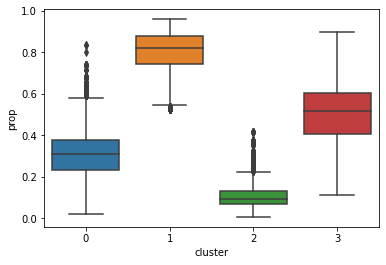

In [30]:
sns.boxplot(data=Xtrain,x="cluster",y="prop")

In [31]:
import sklearn.cluster as cluster
for i in range(2,10):
    labels=cluster.KMeans(n_clusters=i,random_state=200).fit(shap_values).labels_
    print ("Silhouette score for k(clusters) = "+str(i)+" is "\
        +str(silhouette_score(shap_values,labels,metric="euclidean",random_state=200,sample_size=10000)))

Silhouette score for k(clusters) = 2 is 0.6332842228543607
Silhouette score for k(clusters) = 3 is 0.6182342491163073
Silhouette score for k(clusters) = 4 is 0.5957334967492629
Silhouette score for k(clusters) = 5 is 0.37840720849868964
Silhouette score for k(clusters) = 6 is 0.37264166840259083
Silhouette score for k(clusters) = 7 is 0.3765918827192966
Silhouette score for k(clusters) = 8 is 0.43352853140235686
Silhouette score for k(clusters) = 9 is 0.46427657253422866


### 聚类

In [32]:
fig.savefig("./Plots/optimK.jpg",dpi=300)

In [33]:
kmeans = KMeans(n_clusters=4,init="k-means++")
kmeans.fit(shap_values)
cluster_labels = kmeans.labels_
pred=catboost.predict_proba(Xtrain)[:,1]

In [34]:
Xtrain['cluster']=cluster_labels
Xtrain['prop']=pred

In [44]:
clusters=Xtrain.groupby("cluster")['prop'].mean().sort_values().index

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating i

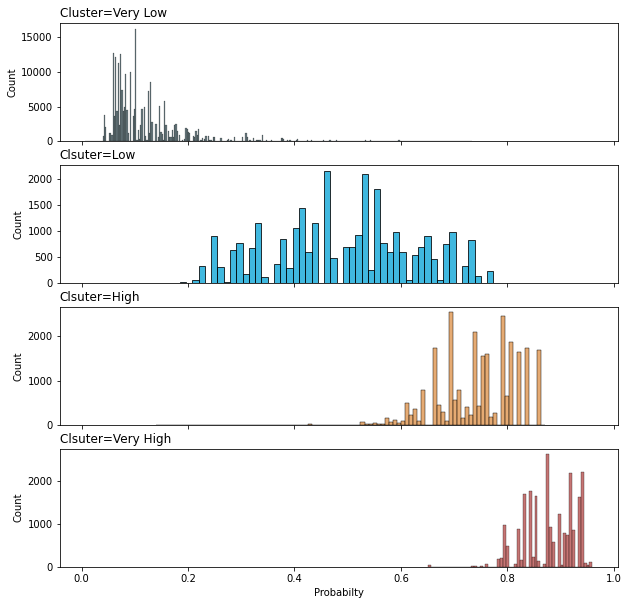

In [49]:
fig,(ax1,ax2,ax3,ax4)=plt.subplots(4,1,sharex=True,figsize=(10,10))
#fig.tight_layout()
sns.histplot(data=Xtrain[Xtrain['cluster']==clusters[0]],x='prop',ax=ax1,color="#374E54")
sns.histplot(data=Xtrain[Xtrain['cluster']==clusters[1]],x='prop',ax=ax2,color="#00A1D5")
sns.histplot(data=Xtrain[Xtrain['cluster']==clusters[2]],x='prop',ax=ax3,color="#DE8F44")
sns.histplot(data=Xtrain[Xtrain['cluster']==clusters[3]],x='prop',ax=ax4,color="#B34745")
ax4.set(xlabel="Probabilty")
ax1.set_title("Cluster=Very Low",loc="left")
ax2.set_title("Clsuter=Low",loc="left")
ax3.set_title("Clsuter=High",loc="left")
ax4.set_title("Clsuter=Very High",loc="left")
fig.savefig("./Plots/cluster_prop.jpg",dpi=300)

In [12]:
Xtrain.groupby("cluster").agg({
    'basesef':pd.Series.mode,
    'baseucva':np.median,
    'prop':np.median,
    'familyHistory':pd.Series.mode,
    'basegrd':pd.Series.median
})

The provided callable <function median at 0x00000257E2B38430> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'median' instead.


,basesef,baseucva,prop,familyHistory,basegrd
cluster,,,,,
0,2,5.0,0.092920,2,2.0
1,3,4.3,0.821656,1,5.0
2,2,4.7,0.309501,1,3.0
3,3,4.7,0.516934,2,4.0


In [54]:
Xtrain.to_csv("./Data/sankeyData.csv",index=False)
clusters

Index([0, 3, 2, 1], dtype='int32', name='cluster')

#### Fairness

In [72]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import count, \
                              false_positive_rate, \
                              selection_rate
from sklearn.metrics import recall_score

In [55]:
ypred=catboost.predict(Xtrain)

In [54]:
my_metrics = {
    'tpr' : recall_score,
    'fpr' : false_positive_rate,
    'sel' : selection_rate,
    'count' : count
}

In [60]:
mf = MetricFrame(
    metrics=my_metrics,
    y_true=ytrain,
    y_pred=ypred,
    sensitive_features=Xtrain.basegrd
)

In [61]:
mf.overall

tpr           0.860559
fpr           0.197974
sel           0.213269
count    311606.000000
dtype: float64

In [69]:
mf.by_group

,tpr,fpr,sel,count
basegrd,,,,
1,0.441176,0.032852,0.034937,93196.0
2,0.694853,0.096019,0.102760,48326.0
3,0.819977,0.168091,0.180013,47080.0
4,0.883634,0.269951,0.288625,43773.0
5,0.927177,0.394011,0.417859,42366.0
6,0.941007,0.502013,0.526841,36865.0
